In [47]:
# Udacity course DataScience
# Project I "How to breakt into the field?"
# Analysis on Seattle AirBnB data

# Import needed libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load Airbnb data into dataframe
df_calendar = pd.read_csv('./Seattle/calendar.csv')
df_listings = pd.read_csv('./Seattle/listings.csv')
df_reviews = pd.read_csv('./Seattle/reviews.csv')

# Show head to get a feeling of the data
#df_calendar.head()
df_listings.head()
#df_reviews.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [42]:
# Price column contains NaN values for unavailable listings. Fill them with 0.
df_calendar['price'].fillna(0, inplace=True)
# Date column is a string value. Convert them to Python datetime for easy access via dt
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
# Create new columns for year, month, day
df_calendar['year'] = df_calendar['date'].dt.year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['day'] = df_calendar['date'].dt.day
# Remove "$" from price column and convert it to float
df_calendar['price'].replace('\$|,','', regex=True, inplace=True)
df_calendar['price'] = df_calendar['price'].astype('float')

# Filter only for available listings
df_available_listings = df_calendar[df_calendar['available'] == 't']

#Calculate avg price per month for available listings
arr_avg_price_month = []
for month in range(1,13):
    arr_avg_price_month.append(df_available_listings[df_available_listings['month'] == month]['price'].mean())

1    64937
2    73321
3    83938
4    76037
5    79971
Name: month, dtype: int64

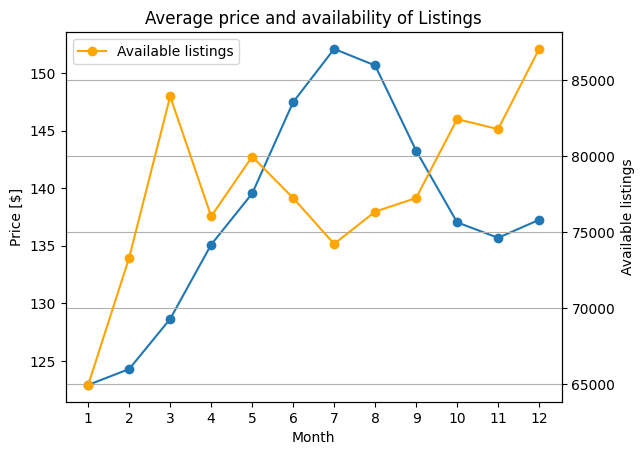

In [46]:
# Plot data to answer Question Nr. 1
fig, ax = plt.subplots()
ax.plot(range(1,1+len(arr_avg_price_month)), arr_avg_price_month, label='Average price', marker='o')

ax.set_xlabel('Month')
ax.set_xticks(range(1,1+len(arr_avg_price_month)))
ax.set_ylabel('Price [$]')

ax2 = ax.twinx()
ax2.plot(df_available_listings['month'].value_counts().sort_index(), label='Available listings', marker='o', color='orange')
ax2.set_ylabel('Available listings')

plt.grid()
plt.title('Average price and availability of Listings')
plt.legend()
plt.show()

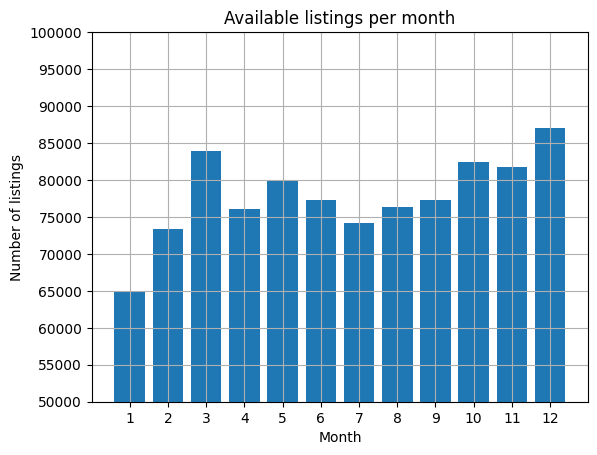